# Trabajo práctico 1 



In [600]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from collections import defaultdict

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 17
np.random.seed(0)


## Ejercicio 1 - Implementar clase PCA con numpy
**Dataset** Human activity recognition

Tomar las primeras 63 componentes principales y calcular la varianza contemplada. Realizar las operaciones internas con numpy.linalg. 

In [5]:
# Cargo el dataset de entrenamiento y lo separo en X e Y
path = "Datasets"
full_dataset_train = pd.read_csv(path + "/" + "HAR-train.csv")
x_train = full_dataset_train.iloc[:,:-1]
y_train = full_dataset_train["Activity"]

In [6]:
x_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819,30
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053,30
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811,30
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339,30


In [7]:
y_train

0               STANDING
1               STANDING
2               STANDING
3               STANDING
4               STANDING
              ...       
7347    WALKING_UPSTAIRS
7348    WALKING_UPSTAIRS
7349    WALKING_UPSTAIRS
7350    WALKING_UPSTAIRS
7351    WALKING_UPSTAIRS
Name: Activity, Length: 7352, dtype: object

In [8]:
# Cantidad única de clases
clases = np.unique(y_train)
n_clases = len(clases)
clases

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [9]:
#Creo un dataframe de y_train para asignarle un número a cada clase
y_train_table = {
    "N": np.arange(1,len(clases)+1),
    "Clase": clases,
}
y_train_df = pd.DataFrame(y_train_table)

In [10]:
y_train_df

,N,Clase
0,1,LAYING
1,2,SITTING
2,3,STANDING
3,4,WALKING
4,5,WALKING_DOWNSTAIRS
5,6,WALKING_UPSTAIRS


In [11]:
y_train_dict = {
    clases[0]: 1,
    clases[1]: 2,
    clases[2]: 3,
    clases[3]: 4,
    clases[4]: 5,
    clases[5]: 6
}

In [12]:
y_train_dict

{'LAYING': 1,
 'SITTING': 2,
 'STANDING': 3,
 'WALKING': 4,
 'WALKING_DOWNSTAIRS': 5,
 'WALKING_UPSTAIRS': 6}

In [13]:
new_y_train = []
for i in range(0, len(y_train)):
    new_y_train.append(y_train_dict[y_train[i]])      

### Aplicamos PCA

In [14]:
# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

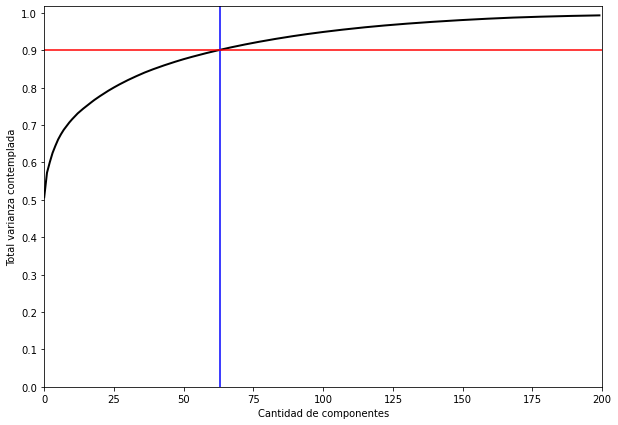

In [15]:
# Pido que me seleccione las primeraas 63 componentes y me calcule la varianza contemplada
componentes = 63

pca = PCA(n_components = componentes, random_state = RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)
pca_full = PCA(n_components = 200, random_state = RANDOM_STATE).fit(X_scaled)

varianza = np.cumsum(pca_full.explained_variance_ratio_)[componentes-1]

plt.figure(figsize = (10,7))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), color = 'k', lw = 2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(componentes, c = 'b')
plt.axhline(varianza, c = 'r')
plt.show();

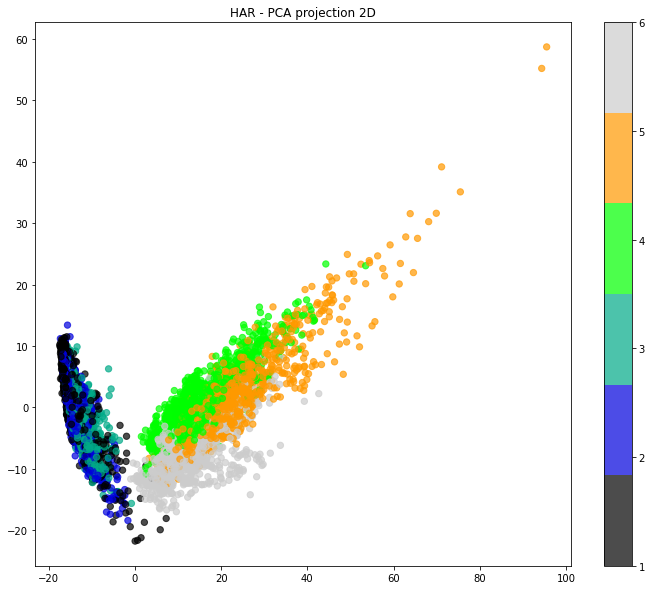

In [16]:
# Graficamos los primeros dos componentes
plt.figure(figsize = (12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = new_y_train, alpha = 0.7, s = 40, cmap = plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False #Evita un warning
plt.colorbar()
plt.title('HAR - PCA projection 2D');

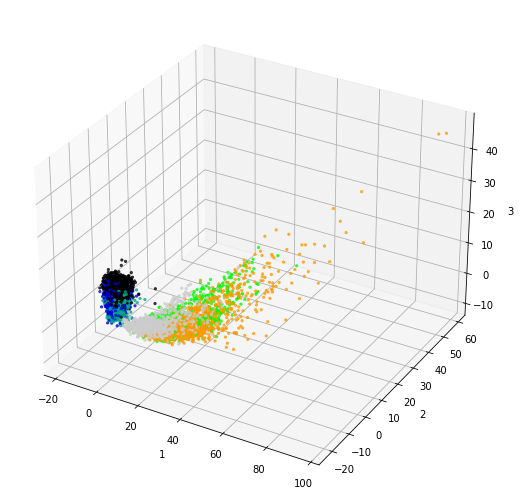

In [17]:
# Graficamos los primeros tres componentes
# El enunciado no pedía graficar en 3 dimensiones, pero me pareció interesante mostrarlo
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

ax.scatter(x, y, z, c = new_y_train, alpha = 0.7, s = 5, cmap = plt.cm.get_cmap('nipy_spectral', 6))

ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

plt.show()

## Ejercicio 2 - Implementar clase KMeans con numpy
**Dataset** Human activity recognition

Implementar kmeans con numpy. Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de k=2 y 6. Graficar los casos de k=2 y k=6 con las primeras dos componentes principales.

In [569]:
data = []
for r in range(len(x_train)):
    d =  np.array(x_train.iloc[r,:])
    data.append(d)

## Para K = 6

In [575]:
K = 6

class point():
    def __init__(self, data):
        self.data = data
        self.k = np.random.randint(0, K)
    
    def __repr__(self):
        return str({"data":self.data, "k":self.k})
    
def make_k_mapping(points):
    point_dict = defaultdict(list)
    for p in points:
        point_dict[p.k] = point_dict[p.k] + [p.data]
    return point_dict

def calc_k_means(point_dict):
    means = [np.mean(point_dict[k],axis=0) for k in range(K)]
    return means

def update_k(points,means):
    for p in points:   
        dists = [np.linalg.norm(means[k]-p.data) for k in range(K)]
        p.k = np.argmin(dists)
        
def fit(points, epochs = 10):
    for e in range(epochs):
        point_dict = make_k_mapping(points)
        means = calc_k_means(point_dict)
        update_k(points, means)
    return means, points

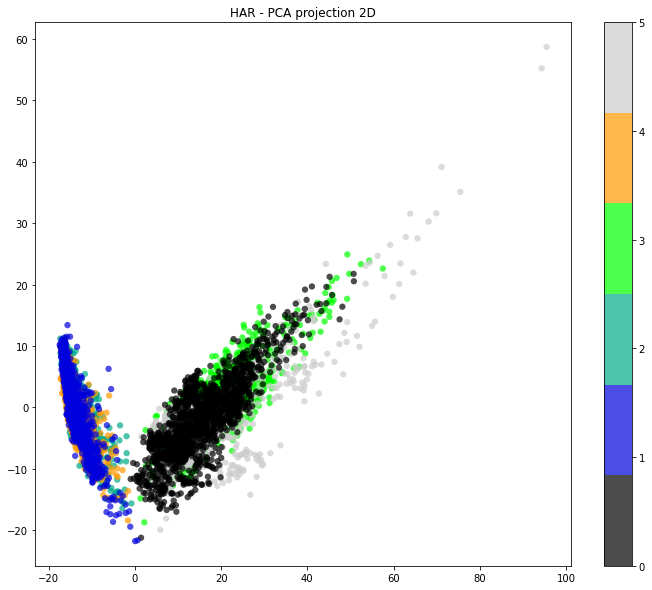

In [576]:
points = [point(d) for d in data]

new_means, new_points = fit(points)

new_ks = []
for i in range(len(new_points)):
    p = new_points[i].k
    new_ks.append(p)

new_ks = np.array(new_ks)
    
plt.figure(figsize = (12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = new_ks, edgecolor = 'none', alpha = 0.7, s = 40, cmap = plt.cm.get_cmap('nipy_spectral', len(np.unique(new_ks))))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D');

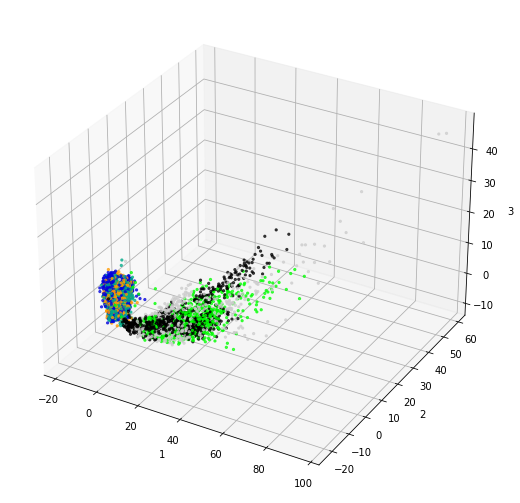

In [577]:
# Graficamos los primeros tres componentes
# El enunciado no pedía graficar en 3 dimensiones, pero me pareció interesante mostrarlo
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

ax.scatter(x, y, z, c = new_ks, alpha = 0.7, s = 5, cmap = plt.cm.get_cmap('nipy_spectral', len(np.unique(new_ks))))

ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

plt.show()

In [578]:
df_aux = pd.DataFrame({
    "A": y_train,
    "B": new_ks})

tab = pd.crosstab(df_aux["A"], df_aux["B"], margins = True)
tab.index = clases.tolist() + ["ALL"]
tab.columns = ['cluster ' + str(i + 0) for i in range(len(np.unique(new_ks)))] + ["ALL"]
tab

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,ALL
LAYING,1,513,376,8,507,2,1407
SITTING,0,475,344,1,466,0,1286
STANDING,0,499,381,0,494,0,1374
WALKING,519,0,0,371,0,336,1226
WALKING_DOWNSTAIRS,443,0,0,278,0,265,986
WALKING_UPSTAIRS,476,0,0,302,0,295,1073
ALL,1439,1487,1101,960,1467,898,7352


Esta tabla no refleja una asignación correcta si lo que queríamos era un cluster por etiqueta. Pero de todas maneras puede notarse un patrón: los clusters 1, 2 y 4 corresonden a las actividades que no involucren movimiento, y los clusters 0, 3 y 5 corresponden a las actividades que implican movimiento.

## Para K = 2

In [601]:
K = 2

#np.random.seed(2)

class point():
    def __init__(self, data):
        self.data = data
        self.k = np.random.randint(0, K)
    
    def __repr__(self):
        return str({"data":self.data, "k":self.k})
    
def make_k_mapping(points):
    point_dict = defaultdict(list)
    for p in points:
        point_dict[p.k] = point_dict[p.k] + [p.data]
    return point_dict

def calc_k_means(point_dict):
    means = [np.mean(point_dict[k],axis=0) for k in range(K)]
    return means

def update_k(points,means):
    for p in points:   
        dists = [np.linalg.norm(means[k]-p.data) for k in range(K)]
        p.k = np.argmin(dists)
        
def fit(points, epochs = 10):
    for e in range(epochs):
        point_dict = make_k_mapping(points)
        means = calc_k_means(point_dict)
        update_k(points, means)
    return means, points

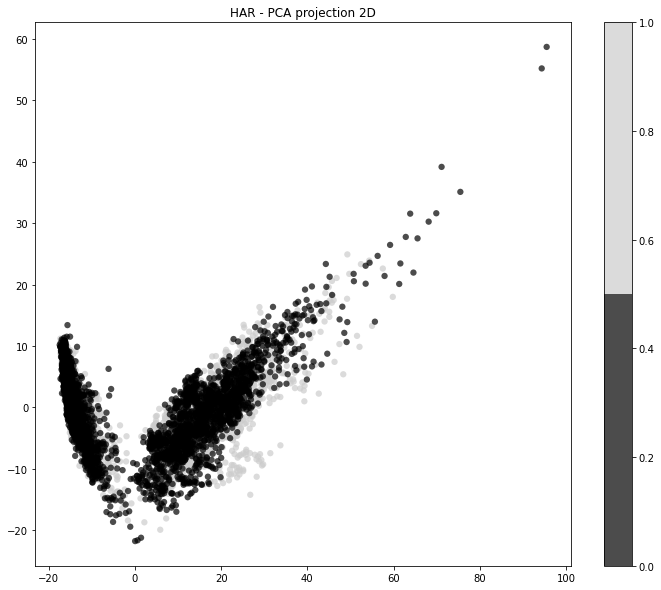

In [602]:
points = [point(d) for d in data]

new_means, new_points = fit(points)

new_ks = []
for i in range(len(new_points)):
    p = new_points[i].k
    new_ks.append(p)

plt.figure(figsize = (12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = new_ks, edgecolor = 'none', alpha = 0.7, s = 40, cmap = plt.cm.get_cmap('nipy_spectral', len(np.unique(new_ks))))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D');

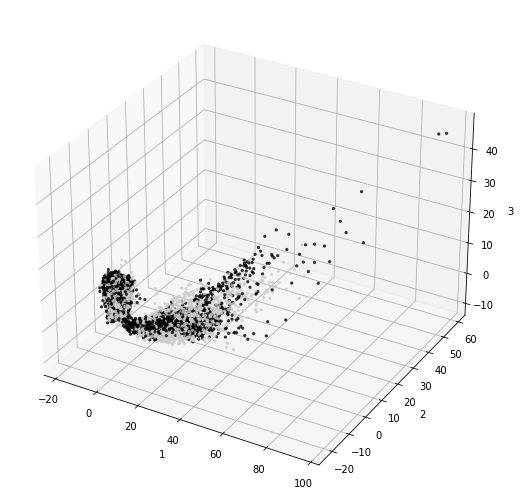

In [603]:
# El enunciado no pedía graficar en 3 dimensiones, pero me pareció interesante mostrarlo
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

ax.scatter(x, y, z, c = new_ks, alpha = 0.7, s = 5, cmap = plt.cm.get_cmap('nipy_spectral', len(np.unique(new_ks))))

ax.set_xlabel('1')
ax.set_ylabel('2')
ax.set_zlabel('3')

plt.show()

In [604]:
df_aux = pd.DataFrame({
    "A": y_train,
    "B": new_ks})

tab = pd.crosstab(df_aux["A"], df_aux["B"], margins = True)
tab.index = clases.tolist() + ["ALL"]
tab.columns = ['cluster ' + str(i + 0) for i in range(len(np.unique(new_ks)))] + ["ALL"]
tab

,cluster 0,cluster 1,ALL
LAYING,830,577,1407
SITTING,759,527,1286
STANDING,802,572,1374
WALKING,571,655,1226
WALKING_DOWNSTAIRS,482,504,986
WALKING_UPSTAIRS,516,557,1073
ALL,3960,3392,7352


Eligiendo 2 clusters, el modelo no logra una buena separación. Se probó con otro seed (seed = 2), y en ese caso el modelo separó casi perfectamente las actividades que implican movimiento de las que no. 

## Ejercicio 3 - Comparar los ejercicios anteriores con lo visto en las clases

* Cuando se corre un modelo Kmeans, el azar juega un rol muy importante en la obtención de resultados, puesto que la asignación de clusters al principio del algoritmo es totalmente aleatoria y los resultado dependen en gran medida de esto. Es por ello que se consiguieron diferentes resultados a lo hecho en clases. Se podrían correr varios modelos para diferentes seeds (o simplemente quitar la semilla), e ir comparando resultados para quedarse con lo que consideremos sería una mejor asignación.

* Como conclusión de esta primera parte, quería decir que al elegir un k igual a la cantidad de etiquetas no siempre va a separar como nosotros quisiéramos los datos, es decir en un cluster perfecto por cada etiqueta. Esto se debe en parte a que kmeans en un algoritmo de aprendizaje no supervisado, por lo que agrupa datos semejantes en base a una distancia. El modelo nunca solicitó como información la etiqueta. Es un ejercicio muy interesante utilizar kmeans con etiquetas para ver las diferencias de asignación y entender cómo trabaja el algoritmo.